# **Thiết lập môi trường**

In [1]:
import os
import json
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
ROOT = ''

..


## **Định nghĩa các biến thư mục**

In [2]:
ROOT = ".."
DATA_PATH = os.path.join(ROOT, "data")
MODEL_PATH = os.path.join(ROOT, "model")
TEXT_PATH = os.path.join(MODEL_PATH, "text")

IIIT5K_DATASET = {
    'data_path': os.path.join(DATA_PATH, "IIIT5K"),
    'image_train': os.path.join(DATA_PATH, "IIIT5K", "train"),
    'image_test': os.path.join(DATA_PATH, "IIIT5K", "test"),
    'train_data': os.path.join(DATA_PATH, "IIIT5K", "traindata_processed.csv"),
    'test_data': os.path.join(DATA_PATH, "IIIT5K", "testdata_processed.csv"),
}


VIETOCR_DATASET = {
    'data_path': os.path.join(DATA_PATH, "VIETOCR"),
    'image_path': os.path.join(DATA_PATH, "VIETOCR", "images"),
    'data': os.path.join(DATA_PATH, "VIETOCR", "data_processed.csv")
}


VIETNAMESE_PATH = os.path.join(DATA_PATH, "vietnamese")
VIETNAMESE_DATASET = {
    'labels': os.path.join(VIETNAMESE_PATH, 'labels'),
    'train_images': os.path.join(VIETNAMESE_PATH, 'train_images'),
    'test_images': os.path.join(VIETNAMESE_PATH, 'test_images'),
    'unseen_images': os.path.join(VIETNAMESE_PATH, 'unseen_test_images'),
    'train_data': os.path.join(VIETNAMESE_PATH, 'train_data.csv'),
    'test_data': os.path.join(VIETNAMESE_PATH, 'test_data.csv'),
    'train_cropped_images': os.path.join(VIETNAMESE_PATH, 'cropped_images', 'train'),
    'test_cropped_images': os.path.join(VIETNAMESE_PATH, 'cropped_images', 'test')
}

## **Định nghĩa thiết bị sử dụng**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Tải các dữ liệu cần thiết**

## Tải dữ liệu đã được xử lý và chia thành train, validation và test

In [10]:
def load_csv_file(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)

    return df


train_data = load_csv_file(IIIT5K_DATASET['train_data'])
test_data = load_csv_file(IIIT5K_DATASET['test_data'])

print(f"Số lượng dữ liệu train: {len(train_data)}")
print(f"Số lượng dữ liệu test: {len(test_data)}")

Số lượng dữ liệu train: 4000
Số lượng dữ liệu test: 1000


## Tải từ điển

In [6]:
vocab_path = os.path.join(TEXT_PATH, "vocab.json")
with open(vocab_path, "r") as f:
    vocab = json.load(f)

print(f"Đã tải từ điển, số lượng từ vựng: {len(vocab['char2idx'])}")

Đã tải từ điển, số lượng từ vựng: 108


# **Định nghĩa lớp Dataset**

In [7]:
class OCRDataset(Dataset):
    def __init__(self, dataframe, image_root, transform, max_len):
        self.data = dataframe
        self.image_root = image_root
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_root, row['ImgName'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        token_ids = row['token_ids']
        if isinstance(token_ids, str):
            token_ids = ast.literal_eval(token_ids)
        token_ids = token_ids[:self.max_len]  # truncate
        token_ids = torch.tensor(token_ids, dtype=torch.long)
        return image, token_ids

## Hàm collate cho DataLoader

In [8]:
def collate_fn(batch):
    images, sequences = zip(*batch)
    input_seqs = [seq[:-1] for seq in sequences]
    target_seqs = [seq[1:] for seq in sequences]
    padded_input = pad_sequence(input_seqs, batch_first=True, padding_value=0)
    padded_target = pad_sequence(target_seqs, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(seq) - 1 for seq in sequences], dtype=torch.long)
    mask = (padded_target != 0).long()
    return torch.stack(images), padded_input, padded_target, lengths, mask

## **Tạo Transform ảnh**

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.RandomRotation(2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Tạo Dataset và DataLoader

In [11]:
BATCH_SIZE = 16
MAX_LEN = 50


train_dataset = OCRDataset(train_data, image_root=IIIT5K_DATASET['data_path'], transform=train_transform, max_len=MAX_LEN)
test_dataset = OCRDataset(test_data, image_root=IIIT5K_DATASET['data_path'], transform=test_transform, max_len=MAX_LEN)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    num_workers=0, 
    shuffle=True, 
    pin_memory=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    num_workers=0, 
    shuffle=False, 
    pin_memory=True,
    collate_fn=collate_fn
)

## Kiểm tra DataLoader

In [12]:
start_time = time.time()
# Lấy một batch mẫu từ train_loader
batch = next(iter(train_loader))
end_time = time.time()
print(f"Thời gian lấy dữ liệu: {end_time - start_time} giây")

print(batch[1][0])
print(batch[2][0])

Thời gian lấy dữ liệu: 1.8086867332458496 giây
tensor([ 1, 17, 19, 32, 34, 23, 20, 23, 19, 18,  0])
tensor([17, 19, 32, 34, 23, 20, 23, 19, 18,  2,  0])


# Định nghĩa các lớp mô hình

## Lớp PosittionEncoding

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

## CNN trích xuất đặc trưng ảnh

In [14]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # Sử dụng ResNet backbone
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        
        # Thay vì pooling cứng, dùng convolution để giảm chiều
        self.feature_conv = nn.Sequential(
            nn.Conv2d(512, d_model, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
        
        # Learnable 2D positional encoding for images
        self.pos_embedding_h = nn.Parameter(torch.randn(32, d_model) * 0.02)  # Max height
        self.pos_embedding_w = nn.Parameter(torch.randn(128, d_model) * 0.02)  # Max width

    def forward(self, x):
        # x: (B, 3, 32, 128)
        features = self.feature_extractor(x)  # (B, 512, H', W')
        features = self.feature_conv(features)  # (B, d_model, H', W')
        
        B, C, H, W = features.shape
        
        # Add 2D positional encoding
        pos_h = self.pos_embedding_h[:H].unsqueeze(1).unsqueeze(0).repeat(1, 1, W, 1)  # (1, H, W, d_model)
        pos_w = self.pos_embedding_w[:W].unsqueeze(0).unsqueeze(0).repeat(1, H, 1, 1)  # (1, H, W, d_model)
        pos_encoding = (pos_h + pos_w).permute(0, 3, 1, 2)  # (1, d_model, H, W)
        
        features = features + pos_encoding
        
        # Flatten spatial dimensions: (B, d_model, H, W) -> (B, H*W, d_model)
        features = features.view(B, C, H * W).permute(0, 2, 1)
        features = self.norm(features)
        
        return features

## Lớp MultiHead Cross Attention

In [15]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, key_padding_mask=None):
        attn_output, attn_weights = self.multihead_attn(
            query=query,
            key=key,
            value=value,
            key_padding_mask=key_padding_mask
        )
        # Residual connection
        output = self.norm(query + self.dropout(attn_output))
        return output, attn_weights

## Lớp Transfomrer Decoder

In [16]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=4, dropout=0.1, max_text_len=128):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_text_len)
        self.dropout = nn.Dropout(dropout)
        
        # Custom decoder layers with cross-attention
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn': nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True),
                'cross_attn': MultiHeadCrossAttention(d_model, nhead, dropout=dropout),
                'ffn': nn.Sequential(
                    nn.Linear(d_model, 4 * d_model),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(4 * d_model, d_model)
                ),
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
                'norm3': nn.LayerNorm(d_model),
            })
            for _ in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        # tgt: (B, L_text), memory: (B, S_img, D)
        B, L = tgt.shape
        
        # Token embedding + positional encoding
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoder(tgt_emb)
        tgt_emb = self.dropout(tgt_emb)
        
        # Store attention weights for visualization
        cross_attention_weights = []
        
        x = tgt_emb
        for layer in self.layers:
            # Self-attention
            attn_output, _ = layer['self_attn'](
                query=x, key=x, value=x,
                attn_mask=tgt_mask,
                key_padding_mask=tgt_key_padding_mask
            )
            x = layer['norm1'](x + self.dropout(attn_output))
            
            # Cross-attention with image features
            cross_attn_output, cross_attn_weights = layer['cross_attn'](
                query=x,
                key=memory,
                value=memory
            )
            cross_attention_weights.append(cross_attn_weights)
            x = layer['norm2'](x + cross_attn_output)
            
            # Feed-forward
            ffn_output = layer['ffn'](x)
            x = layer['norm3'](x + self.dropout(ffn_output))
        
        logits = self.output_layer(x)
        
        # Return both logits and attention weights
        return logits, cross_attention_weights

## Lớp OCR kết hợp các lớp trên

In [17]:
class OCRModel(nn.Module):    
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=4, dropout=0.1, max_text_len=128):
        super().__init__()
        self.cnn = CNNFeatureExtractor(d_model)
        self.decoder = TransformerDecoder(
            vocab_size=vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dropout=dropout,
            max_text_len=max_text_len
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, images, input_seqs, tgt_mask=None, tgt_key_padding_mask=None, return_attention=False):
        # Extract features from images
        memory = self.cnn(images)  # (B, S, D)
        
        # Decode text
        logits, attention_weights = self.decoder(
            tgt=input_seqs,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )
        
        if return_attention:
            return logits, attention_weights
        return logits

    def generate(self, images, max_length=128, start_token=1, end_token=2, device='cuda', beam_width=5):
        """
        Generate sequences using beam search.
        """
        self.eval()
        with torch.no_grad():
            batch_size = images.size(0)
            assert batch_size == 1, "Beam search hiện tại chỉ hỗ trợ batch size = 1"
            
            memory = self.cnn(images)  # (1, S, D)
            
            # Mỗi beam là (sequence, score)
            beams = [(torch.tensor([start_token], device=device), 0.0)]
            
            for _ in range(max_length - 1):
                new_beams = []
                for seq, score in beams:
                    if seq[-1].item() == end_token:
                        # Nếu đã có end_token thì giữ nguyên beam này
                        new_beams.append((seq, score))
                        continue
                    
                    # Tạo mask cho decoder
                    tgt_mask = self._generate_square_subsequent_mask(len(seq), device)
                    
                    # Dự đoán logits cho seq hiện tại
                    logits, _ = self.decoder(seq.unsqueeze(0), memory, tgt_mask=tgt_mask)
                    logits = logits[:, -1, :]  # (1, vocab_size)
                    log_probs = F.log_softmax(logits, dim=-1).squeeze(0)  # (vocab_size,)
                    
                    # Lấy top beam_width token
                    top_log_probs, top_indices = torch.topk(log_probs, beam_width)
                    
                    # Tạo các beam mới
                    for log_p, idx in zip(top_log_probs, top_indices):
                        new_seq = torch.cat([seq, idx.unsqueeze(0)])
                        new_score = score + log_p.item()
                        new_beams.append((new_seq, new_score))
                
                # Chọn beam_width beams có điểm cao nhất (log prob lớn nhất)
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
                
                # Nếu tất cả beams đều kết thúc bằng end_token thì dừng
                if all(seq[-1].item() == end_token for seq, _ in beams):
                    break
            
            # Lấy beam có score cao nhất
            best_seq, best_score = beams[0]
            return best_seq.unsqueeze(0)  # shape (1, seq_len)
    
    def _generate_square_subsequent_mask(self, size, device):
        """Generate causal mask for decoder"""
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask.to(device)

## Lớp Label Smoothing

Dùng cho phần tính toán loss

In [18]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1, ignore_index=0):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        # pred: (B, L, V), target: (B, L)
        B, L, V = pred.shape
        
        # Create one-hot with label smoothing
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (V - 1))
        true_dist.scatter_(2, target.unsqueeze(2), 1.0 - self.smoothing)
        
        # Mask padding tokens
        mask = (target != self.ignore_index)
        true_dist = true_dist * mask.unsqueeze(2)
        
        # Compute loss
        log_pred = F.log_softmax(pred, dim=-1)
        loss = -torch.sum(true_dist * log_pred) / mask.sum()
        
        return loss

# Định nghĩa các hàm

## Hàm huấn luyện 1 epoch

In [19]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device, epoch=0, clip_grad=1.0):
    model.train()
    total_loss = 0.0
    total_tokens = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)

    for images, input_seqs, target_seqs, lengths, padding_mask in loop:
        images = images.to(device)
        input_seqs = input_seqs.to(device)
        target_seqs = target_seqs.to(device)
        padding_mask = padding_mask.to(device)

        optimizer.zero_grad()

        # Tạo causal mask (T, T)
        T = input_seqs.size(1)
        tgt_mask = torch.triu(torch.ones(T, T, device=device), diagonal=1).bool()
        tgt_mask = tgt_mask.masked_fill(tgt_mask, float('-inf'))

        # True tại vị trí cần mask (PAD)
        tgt_key_padding_mask = (padding_mask == 0)

        # Forward
        logits = model(
            images,
            input_seqs,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )  # (B, T, V)

        # Tính loss
        loss = loss_fn(logits, target_seqs)

        loss.backward()

        if clip_grad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        # Tính số token không phải padding
        non_pad = (target_seqs != 0)
        total_loss += loss.item() * non_pad.sum().item()
        total_tokens += non_pad.sum().item()

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0.0
    print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}")
    return avg_loss

## Hàm huấn luyện toàn bộ mô hình

In [20]:
def train_model(
    model,
    train_loader,
    model_folder,
    device="cuda",
    num_epochs=20,
    lr=1e-3,
    clip_grad=1.0,
    resume=False,
    smoothing=0.1,
    vocab_size=None,
    freeze_epoch=3,
    loss_path_name="train_losses.json"
):
    assert vocab_size is not None, "Cần truyền vocab_size để khởi tạo LabelSmoothingLoss"

    os.makedirs(os.path.join(model_folder, "history"), exist_ok=True)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = LabelSmoothingLoss(num_classes=vocab_size, smoothing=smoothing, ignore_index=0)

    # Scheduler sẽ giảm lr nếu loss không cải thiện sau 3 epoch
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    model_path = os.path.join(model_folder, "ocr_model.pth")
    train_losses_path = os.path.join(model_folder, "history", loss_path_name)

    start_epoch = 0
    train_losses = []

    if resume:
        if os.path.exists(model_path):
            try:
                checkpoint = torch.load(model_path, map_location=device)
                model.load_state_dict(checkpoint["model_state_dict"])
                optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
                start_epoch = checkpoint.get("epoch", 0) + 1
                print(f"Tiếp tục training từ epoch {start_epoch + 1}")
            except Exception as e:
                print(f"Lỗi khi tải checkpoint: {e}. Bắt đầu train lại từ đầu.")

        if os.path.exists(train_losses_path):
            try:
                with open(train_losses_path, "r") as f:
                    train_losses = json.load(f)
            except Exception as e:
                print(f"Lỗi khi tải train loss: {e}")

    start_time = time.time()

    for epoch in range(start_epoch, num_epochs):
        epoch_start = time.time()

        # # Freeze CNN ở các epoch đầu
        if epoch < freeze_epoch:
            for param in model.cnn.parameters():
                param.requires_grad = False
            print(f"[Epoch {epoch+1}] Encoder (CNN) đã bị freeze.")
        else:
            for param in model.cnn.parameters():
                param.requires_grad = True
            print(f"[Epoch {epoch+1}] Encoder được unfreeze.")

        train_loss = train_one_epoch(
            model=model,
            dataloader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            epoch=epoch,
            clip_grad=clip_grad
        )
        train_losses.append(train_loss)

        print(f"[Epoch {epoch+1}] - Train Loss: {train_loss:.4f}")

        # Cập nhật LR nếu loss không cải thiện
        scheduler.step(train_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"  Learning Rate: {current_lr:.6f}")

        elapsed = time.time() - epoch_start
        total_elapsed = time.time() - start_time
        print(f"  Thời gian epoch: {elapsed:.2f}s | Tổng: {total_elapsed:.2f}s")

        # Lưu checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }, model_path)
        print(f"Đã lưu checkpoint tại {model_path}")

        # Lưu loss history
        with open(train_losses_path, "w") as f:
            json.dump(train_losses, f)

        torch.cuda.empty_cache()

    print("Huấn luyện hoàn tất.")
    return model


## Hàm đánh giá

In [21]:
def evaluate_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    loss_fn = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')  # tính tổng loss
    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    with torch.no_grad():
        for images, input_seqs, target_seqs, lengths, padding_mask in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            input_seqs = input_seqs.to(device)
            target_seqs = target_seqs.to(device)
            padding_mask = padding_mask.to(device)

            # Tạo tgt_mask cho causal decoding
            T = input_seqs.size(1)
            tgt_mask = torch.triu(torch.full((T, T), float('-inf'), device=device), diagonal=1)
            tgt_key_padding_mask = (padding_mask == 0)

            output = model(images, input_seqs, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            output_flat = output.reshape(-1, output.size(-1))         # (B*T, vocab_size)
            target_flat = target_seqs.reshape(-1)                     # (B*T)

            # Tính loss
            loss = loss_fn(output_flat, target_flat)
            total_loss += loss.item()

            non_pad_mask = (target_flat != 0)
            total_tokens += non_pad_mask.sum().item()

            preds = output_flat.argmax(dim=-1)
            correct_tokens += ((preds == target_flat) & non_pad_mask).sum().item()

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss) if avg_loss < 100 else float("inf")
    accuracy = correct_tokens / total_tokens

    print(f"\nEvaluation Results:")
    print(f"==> Token Loss: {avg_loss:.4f}")
    print(f"==> Perplexity : {perplexity:.2f}")
    print(f"==> Accuracy   : {accuracy * 100:.2f}%")
    print(f"==> Total Tokens: {total_tokens}, Batches: {len(test_loader)}\n")

    return avg_loss, perplexity, accuracy


# Khởi tạo các hyperparameter

In [22]:
NUM_EPOCH = 100
LR = 1e-3     # Learning rate
CLIP_GRAD = 1.0
MAX_LEN = 50
VOCAB_SIZE = len(vocab["char2idx"])
PAD_ID = vocab["char2idx"]["<pad>"]

print(f"Kích thước từ điển: {VOCAB_SIZE}")

Kích thước từ điển: 108


# Huấn luyện mô hình

## Khởi tạo mô hình

In [17]:
model = OCRModel(vocab_size=VOCAB_SIZE, d_model=256, nhead=8, num_layers=4, max_text_len=MAX_LEN)
# model = OCRModel(vocab_size=VOCAB_SIZE, d_model=256, nhead=4, num_layers=4, max_text_len=MAX_LEN)

## Huấn luyện mô hình

In [78]:
resume = True

print(f'-----Huấn luyện mô hình OCR-----')
model = train_model(model, train_loader, MODEL_PATH, device,    
            NUM_EPOCH, LR, CLIP_GRAD, resume, 0.05, VOCAB_SIZE, 2)

-----Huấn luyện mô hình OCR-----


C:\Users\hao\AppData\Local\Temp\ipykernel_15560\490701374.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Tiếp tục training từ epoch 96
[Epoch 96] Encoder được unfreeze.


Epoch 96 - Train Loss: 0.6392
[Epoch 96] - Train Loss: 0.6392
  Learning Rate: 0.000250
  Thời gian epoch: 33.79s | Tổng: 33.79s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 97] Encoder được unfreeze.


Epoch 97 - Train Loss: 0.6411
[Epoch 97] - Train Loss: 0.6411
  Learning Rate: 0.000250
  Thời gian epoch: 34.87s | Tổng: 69.48s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 98] Encoder được unfreeze.


Epoch 98 - Train Loss: 0.6388
[Epoch 98] - Train Loss: 0.6388
  Learning Rate: 0.000250
  Thời gian epoch: 33.47s | Tổng: 103.66s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 99] Encoder được unfreeze.


Epoch 99 - Train Loss: 0.6353
[Epoch 99] - Train Loss: 0.6353
  Learning Rate: 0.000250
  Thời gian epoch: 34.78s | Tổng: 139.21s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 100] Encoder được unfreeze.


Epoch 100 - Train Loss: 0.6390
[Epoch 100] - Train Loss: 0.6390
  Learning Rate: 0.000250
  Thời gian epoch: 34.19s | Tổng: 174.09s
Đã lưu checkpoint tại ..\model\ocr_model.pth
Huấn luyện hoàn tất.


## Trực quan giá trị loss

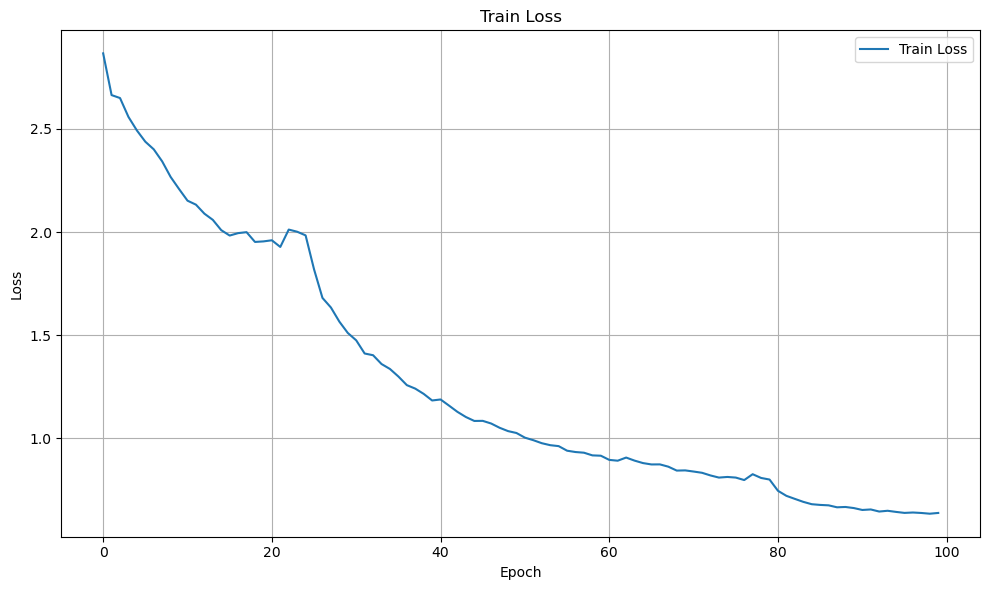

In [81]:
def load_json_file(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    
    return data

def plot_losses(train_loss_file_path):
    """
    Hàm trực quan hóa train loss và val loss từ file torch đã lưu.

    Args:
        loss_file_path (str): Đường dẫn đến file .pt hoặc .pth chứa dict {'train': [...], 'val': [...]}.

    Returns:
        None
    """

    train_losses = load_json_file(train_loss_file_path)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_loss_file = os.path.join(MODEL_PATH, "history", "train_losses.json")
plot_losses(train_loss_file)

## Đánh giá trên tập test

In [82]:
# Đánh giá model chỉ train trên tập IIIT5K
loss, ppl, acc = evaluate_model(model, test_loader, device)

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]d:\conda_envs\machine_learning\lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Evaluating: 100%|██████████| 63/63 [00:03<00:00, 16.03it/s]


Evaluation Results:
==> Token Loss: 1.0936
==> Perplexity : 2.98
==> Accuracy   : 76.94%
==> Total Tokens: 6015, Batches: 63



In [25]:
# Đánh giá model đã fine tune
loss, ppl, acc = evaluate_model(model, test_loader, device)

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

d:\conda_envs\machine_learning\lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Evaluating: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]


Evaluation Results:
==> Token Loss: 1.3200
==> Perplexity : 3.74
==> Accuracy   : 70.86%
==> Total Tokens: 6015, Batches: 63



# Inference

## Tải mô hình đã train

In [23]:
def load_model(model_class, model_path, vocab_size, d_model=512, nhead=8, numlayer=4, max_len=50, device='cuda'):
    """
    Tải mô hình đã lưu từ file .pth

    Args:
        model_class: class của mô hình OCRModel
        model_path: đường dẫn đến file .pth chứa model state_dict
        vocab_size: kích thước từ vựng (vocab_size lúc training)
        d_model: kích thước embedding
        device: 'cuda' hoặc 'cpu'

    Returns:
        model đã load, đã đưa lên device
    """
    model = model_class(vocab_size=vocab_size, d_model=d_model, nhead=nhead, num_layers=numlayer, max_text_len=max_len).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model


# model = load_model(OCRModel, os.path.join(MODEL_PATH, "ocr_model.pth"), VOCAB_SIZE, d_model=256, max_len=MAX_LEN)

## Dự đoán từ test_loader

In [32]:
def decode_tokens(token_list, idx2char):
    chars = []
    for idx in token_list:
        idx = str(idx)
        if idx in idx2char:
            chars.append(idx2char[idx])
        else:
            chars.append("?")  # ký tự thay thế nếu index không có trong idx2char
    return "".join(chars)

def check_sample_generation(model, dataset, index, sos_token, eos_token, idx2char, device, max_len=50):
    model.eval()
    image, target_seq = dataset[index]
    image_input = image.unsqueeze(0).to(device)

    # Dự đoán với model.generate()
    pred_tokens = model.generate(
        image_input, max_length=max_len, start_token=sos_token, end_token=eos_token, device=device
    ).squeeze(0).tolist()

    # Cắt theo eos token
    if eos_token in pred_tokens:
        pred_tokens = pred_tokens[:pred_tokens.index(eos_token)]

    # Xử lý target_seq
    if isinstance(target_seq, torch.Tensor):
        target_tokens = target_seq.cpu().tolist()
        if eos_token in target_tokens:
            target_tokens = target_tokens[:target_tokens.index(eos_token)]
    else:
        target_tokens = target_seq

    pred_str = decode_tokens(pred_tokens, idx2char)
    target_str = decode_tokens(target_tokens, idx2char)

    # Hiển thị ảnh
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title("Ảnh đầu vào")
    plt.show()

    print(f"Ground truth: {target_str}")
    print(f"Prediction  : {pred_str}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


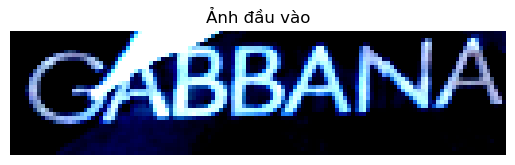

Ground truth: <sos>gabbana
Prediction  : <sos>gabana


In [85]:
check_sample_generation(model, train_dataset, 4, 1, 2, vocab['idx2char'], device, MAX_LEN)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2885156].


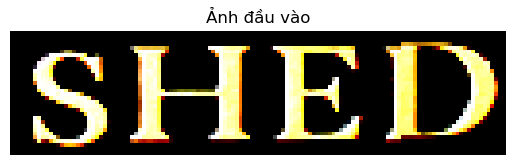

Ground truth: <sos>shed
Prediction  : <sos>shed


In [86]:
check_sample_generation(model, train_dataset, 1006, 1, 2, vocab['idx2char'], device, MAX_LEN)

## Dự đoán từ đường dẫn ảnh truyền vào

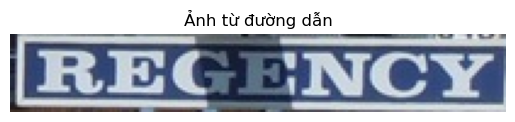

Prediction: <sos>regency


In [87]:
def predict_from_path(model, image_path, transform, sos_token, eos_token, idx2char, device='cuda', max_len=50, beam_width=5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Gọi hàm generate trong model
    pred_tokens = model.generate(
        image_tensor, max_length=max_len, start_token=sos_token, end_token=eos_token,
        device=device, beam_width=beam_width
    ).squeeze(0).tolist()

    if eos_token in pred_tokens:
        pred_tokens = pred_tokens[:pred_tokens.index(eos_token)]

    pred_str = decode_tokens(pred_tokens, idx2char)

    # Hiển thị ảnh
    plt.imshow(image)
    plt.axis("off")
    plt.title("Ảnh từ đường dẫn")
    plt.show()

    print(f"Prediction: {pred_str}")
    return pred_str


infer_tranform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
idx2char = vocab['idx2char']
char2idx = vocab['char2idx']
img_path = os.path.join(IIIT5K_DATASET['image_test'], "69_11.png")
# img_path = os.path.join(VIETOCR_DATASET['image_path'], "98.jpg")
result = predict_from_path(model, img_path, test_transform, char2idx['<sos>'], char2idx['<eos>'], idx2char, max_len=50, beam_width=5)

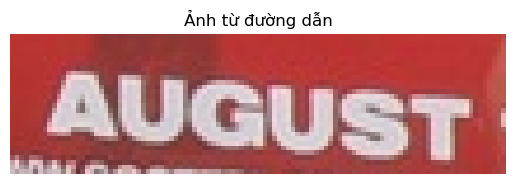

Prediction: <sos>augst


In [ ]:
def predict_from_path(model, image_path, transform, sos_token, eos_token, idx2char, device='cuda', max_len=50, beam_width=5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Gọi hàm generate trong model
    pred_tokens = model.generate(
        image_tensor, max_length=max_len, start_token=sos_token, end_token=eos_token,
        device=device, beam_width=beam_width
    ).squeeze(0).tolist()

    if eos_token in pred_tokens:
        pred_tokens = pred_tokens[:pred_tokens.index(eos_token)]

    pred_str = decode_tokens(pred_tokens, idx2char)

    # Hiển thị ảnh
    plt.imshow(image)
    plt.axis("off")
    plt.title("Ảnh từ đường dẫn")
    plt.show()

    print(f"Prediction: {pred_str}")
    return pred_str


infer_tranform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
idx2char = vocab['idx2char']
char2idx = vocab['char2idx']
img_path = os.path.join(IIIT5K_DATASET['image_test'], "73_12.png")
# img_path = os.path.join(VIETOCR_DATASET['image_path'], "98.jpg")
result = predict_from_path(model, img_path, infer_tranform, char2idx['<sos>'], char2idx['<eos>'], idx2char, max_len=50, beam_width=5)

# **Fine tune trên tập VinAI**

## **Tải dữ liệu**

In [26]:
def load_csv_file(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)

    return df

vnm_train_data = load_csv_file(VIETNAMESE_DATASET['train_data'])
vnm_test_data = load_csv_file(VIETNAMESE_DATASET['test_data'])

print(f"Số lượng dữ liệu train: {len(vnm_train_data)}")
print(f"Số lượng dữ liệu test: {len(vnm_test_data)}")

Số lượng dữ liệu train: 11487
Số lượng dữ liệu test: 3111


## **Tạo transform ảnh**

Tương tự với tập IIIT5K nhưng không có bước resize vì đã resize sẵn

In [27]:
train_transform = transforms.Compose([
    transforms.RandomRotation(2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## **Tạo Dataset và DataLoader (fine-tune ver)**

Sử dụng lại hàm `collate` và các `transform` ở tập **IIIT5k**

In [28]:
BATCH_SIZE = 16
MAX_LEN = 50


train_dataset = OCRDataset(vnm_train_data, image_root=VIETNAMESE_DATASET['train_cropped_images'], transform=train_transform, max_len=MAX_LEN)
test_dataset = OCRDataset(vnm_test_data, image_root=VIETNAMESE_DATASET['test_cropped_images'], transform=test_transform, max_len=MAX_LEN)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    num_workers=0, 
    shuffle=True, 
    pin_memory=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    num_workers=0, 
    shuffle=False, 
    pin_memory=True,
    collate_fn=collate_fn
)

## **Kiểm tra DataLoader**

In [31]:
start_time = time.time()
# Lấy một batch mẫu từ train_loader
batch = next(iter(train_loader))
end_time = time.time()
print(f"Thời gian lấy dữ liệu: {end_time - start_time} giây")

print(batch[1][0])
print(batch[2][0])

Thời gian lấy dữ liệu: 0.20892596244812012 giây
tensor([ 1, 37, 19, 16, 33, 23, 34, 19])
tensor([37, 19, 16, 33, 23, 34, 19,  2])


## **Fine tune mô hình**

### **Khởi tạo lại mô hình**

In [36]:
# Các hyperparameters
NUM_EPOCH = 85
LR = 1e-5     # Learning rate
CLIP_GRAD = 1.0
VOCAB_SIZE = len(vocab["char2idx"])
PAD_ID = vocab["char2idx"]["<pad>"]

# Khởi tạo mô hình
model = OCRModel(vocab_size=VOCAB_SIZE, d_model=256, nhead=8, num_layers=4, max_text_len=MAX_LEN)

# Load mô hình đã train
model = load_model(OCRModel, os.path.join(MODEL_PATH, "ocr_model.pth"), VOCAB_SIZE, d_model=256, max_len=MAX_LEN)

C:\Users\hao\AppData\Local\Temp\ipykernel_20748\1481659153.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


### **Fine tune mô hình**

Freeze 3 epoch đầu để Decode thích nghi trước với dữ liệu mới (tiếng Việt)

In [37]:
resume = True

print(f'-----Huấn luyện mô hình OCR (Fine-tune)-----')
model = train_model(model, train_loader, MODEL_PATH, device,    
            NUM_EPOCH, LR, CLIP_GRAD, resume, 0.05, VOCAB_SIZE, 3, "fine_tune_train_loss.json")

-----Huấn luyện mô hình OCR (Fine-tune)-----


C:\Users\hao\AppData\Local\Temp\ipykernel_20748\1067137200.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Tiếp tục training từ epoch 81
[Epoch 81] Encoder được unfreeze.


Epoch 81 - Train Loss: 0.5949
[Epoch 81] - Train Loss: 0.5949
  Learning Rate: 0.000100
  Thời gian epoch: 90.73s | Tổng: 90.73s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 82] Encoder được unfreeze.


Epoch 82 - Train Loss: 0.5928
[Epoch 82] - Train Loss: 0.5928
  Learning Rate: 0.000100
  Thời gian epoch: 92.65s | Tổng: 184.02s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 83] Encoder được unfreeze.


Epoch 83 - Train Loss: 0.5909
[Epoch 83] - Train Loss: 0.5909
  Learning Rate: 0.000100
  Thời gian epoch: 91.07s | Tổng: 275.74s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 84] Encoder được unfreeze.


Epoch 84 - Train Loss: 0.5877
[Epoch 84] - Train Loss: 0.5877
  Learning Rate: 0.000100
  Thời gian epoch: 99.41s | Tổng: 375.78s
Đã lưu checkpoint tại ..\model\ocr_model.pth
[Epoch 85] Encoder được unfreeze.


Epoch 85 - Train Loss: 0.5873
[Epoch 85] - Train Loss: 0.5873
  Learning Rate: 0.000100
  Thời gian epoch: 91.22s | Tổng: 467.66s
Đã lưu checkpoint tại ..\model\ocr_model.pth
Huấn luyện hoàn tất.


## **Trực quan giá trị loss**

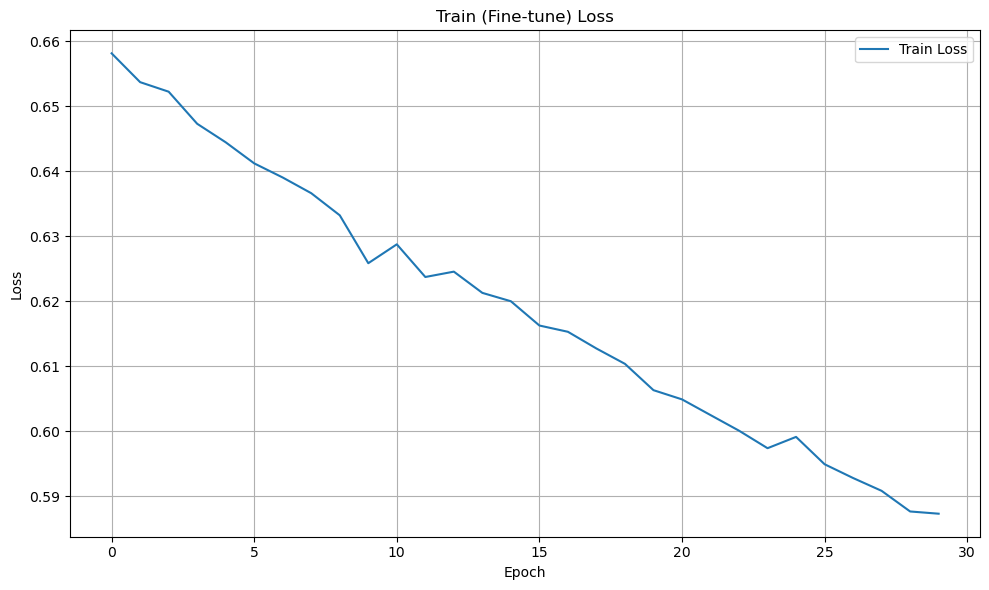

In [38]:
def load_json_file(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    
    return data

def plot_losses(train_loss_file_path):
    """
    Hàm trực quan hóa train loss và val loss từ file torch đã lưu.

    Args:
        loss_file_path (str): Đường dẫn đến file .pt hoặc .pth chứa dict {'train': [...], 'val': [...]}.

    Returns:
        None
    """

    train_losses = load_json_file(train_loss_file_path)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses[-30:], label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train (Fine-tune) Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_loss_file = os.path.join(MODEL_PATH, "history", "fine_tune_train_loss.json")
plot_losses(train_loss_file)

## **Đánh giá trên tập test**

In [57]:
loss, ppl, acc = evaluate_model(model, test_loader, device)

Evaluating:   0%|          | 0/195 [00:00<?, ?it/s]d:\conda_envs\machine_learning\lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Evaluating: 100%|██████████| 195/195 [00:10<00:00, 18.49it/s]


Evaluation Results:
==> Token Loss: 1.1790
==> Perplexity : 3.25
==> Accuracy   : 75.85%
==> Total Tokens: 16296, Batches: 195



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.457983..2.5005665].


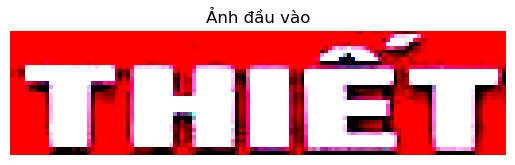

Ground truth: <sos>thiết
Prediction  : <sos>thiết


In [40]:
import random

check_sample_generation(model, train_dataset, random.randint(0, len(train_dataset) - 1), 1, 2, vocab['idx2char'], device, MAX_LEN)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1345534].


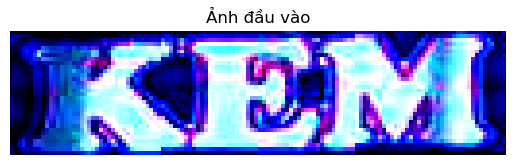

Ground truth: <sos>kem
Prediction  : <sos>kem


In [48]:
check_sample_generation(model, train_dataset, random.randint(0, len(train_dataset) - 1), 1, 2, vocab['idx2char'], device, MAX_LEN)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7172985..2.3235295].


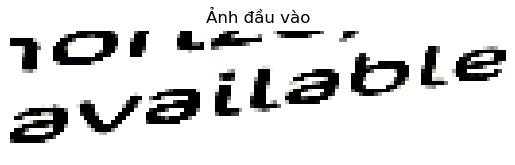

Ground truth: <sos>available
Prediction  : <sos>available


In [56]:
check_sample_generation(model, train_dataset, random.randint(0, len(train_dataset) - 1), 1, 2, vocab['idx2char'], device, MAX_LEN)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1759479].


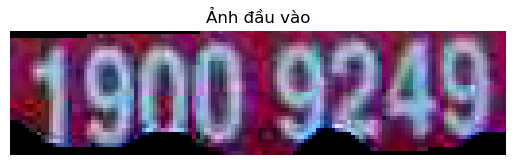

Ground truth: <sos>1900 9248
Prediction  : <sos>1909248


In [60]:
check_sample_generation(model, train_dataset, random.randint(0, len(train_dataset) - 1), 1, 2, vocab['idx2char'], device, MAX_LEN)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


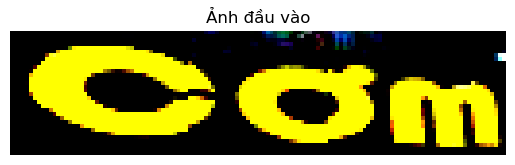

Ground truth: <sos>cơm
Prediction  : <sos>cơm


In [87]:
check_sample_generation(model, train_dataset, random.randint(0, len(train_dataset) - 1), 1, 2, vocab['idx2char'], device, MAX_LEN)

# Fine tune trên tập VietOCR